## A. Lý thuyết

## B. Code

### 1. Cài đặt thư viện cần thiết

In [1]:
# !pip install gymnasium
# !pip install gymnasium[box2d]
# !pip install torch
# !pip install numpy
# !pip install matplotlib

### 2. Import thư viện

In [2]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from collections import deque
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import glob
from IPython.display import Video

### 3. Khởi tạo môi trường gymnasium

In [3]:
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0] 
action_dim = env.action_space.n   

In [4]:
# Sử dụng GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 4. Khởi tạo Q-Network

In [5]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
q_net = QNetwork(state_dim, action_dim).to(device) # Chuyển mạng vào GPU
target_net = QNetwork(state_dim, action_dim).to(device) # Chuyển mạng vào GPU
target_net.load_state_dict(q_net.state_dict()) # Sao chép trọng số từ q_net sang target_net
target_net.eval() # Đặt chế độ đánh giá cho target_net ??

QNetwork(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)

### 5. Khởi tạo các tham số

In [7]:
optimizer = torch.optim.Adam(q_net.parameters(), lr=1e-4) # Sử dụng Adam optimizer
epsilon = 1.0 # Khởi tạo giá trị epsilon cho epsilon-greedy (thêm vào một số ngẫu nhiên để khám phá)
min_epsilon = 0.01 # Giá trị epsilon tối thiểu 
decay = 0.995 # Tỷ lệ giảm epsilon
gamma = 0.99 # Hệ số giảm gamma cho giá trị phần thưởng (discount factor)
batch_size = 128 # Kích thước batch cho việc huấn luyện
episodes = 2000 # Số lượng tập huấn luyện
target_update_freq = 10 # Tần suất cập nhật target network
reward_list = [] # Danh sách lưu trữ phần thưởng cho plot
total_loss = 0 # Tổng giá trị mất mát tại 1 episode
losses = [] # Danh sách lưu trữ giá trị mất mát cho plot
memory = deque(maxlen=100000) # Bộ nhớ để lưu trữ các trải nghiệm

### 6. Epsilon Greedy

In [8]:
def select_action(state, epsilon):
    '''
    Chọn hành động dựa trên epsilon-greedy policy.
    Nếu giá trị ngẫu nhiên nhỏ hơn epsilon, chọn hành động ngẫu nhiên.
    Ngược lại, chọn hành động với giá trị Q cao nhất từ mạng Q.
    '''
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            return q_net(state_tensor).argmax().item()

### 7. Step train

In [9]:
def train_step(batch_size, gamma):
    '''
    Thực hiện một bước huấn luyện.
    1. Lấy một minibatch ngẫu nhiên từ bộ nhớ.
    2. Chuyển đổi các giá trị trong minibatch thành Tensor.
    3. Tính giá trị Q hiện tại cho các trạng thái trong minibatch.
    4. Tính giá trị Q mục tiêu cho các trạng thái tiếp theo.
    5. Tính toán giá trị mất mát giữa giá trị Q hiện tại và giá trị Q mục tiêu.
    6. Cập nhật trọng số của mạng Q bằng cách tối ưu hóa giá trị mất mát.
    '''
    if len(memory) < batch_size:
        return

    # 1. Lấy minibatch ngẫu nhiên
    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    global total_loss

    # 2. Đưa về Tensor
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    dones = np.array(dones)
    
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).unsqueeze(1).to(device)
    rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

    # 3. Tính Q hiện tại
    q_values = q_net(states).gather(1, actions)

    # 4. Tính Q mục tiêu
    with torch.no_grad():
        max_next_q = target_net(next_states).max(1)[0].unsqueeze(1)
        targets = rewards + gamma * max_next_q * (1 - dones)

    # 5. Tính loss và cập nhật mạng
    loss = nn.MSELoss()(q_values, targets)
    total_loss += loss.item()
    
    # 6. Cập nhật mạng
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### 8. Episodes train

In [10]:

for ep in range(episodes):
    '''
    Huấn luyện mạng Q trong một episode.
    1. Reset môi trường và lấy trạng thái ban đầu.
    2. Trong khi chưa kết thúc episode:
        - Chọn hành động dựa trên epsilon-greedy policy.
        - Thực hiện hành động và nhận trạng thái tiếp theo và phần thưởng.
        - Lưu trữ trải nghiệm vào bộ nhớ.
        - Huấn luyện mạng Q bằng cách gọi train_step.
        - Cập nhật trạng thái hiện tại.
    3. Cập nhật target network mỗi vài episode.
    4. Giảm giá trị epsilon.
    5. Lưu trữ phần thưởng vào danh sách reward_list.
    '''
    
    # 1. Reset môi trường và lấy trạng thái ban đầu
    global total_loss
    state, _ = env.reset()
    total_reward = 0

    total_loss = 0
    done = False

    # 2. Chưa kết thúc episode
    while not done:
        action = select_action(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        memory.append((state, action, reward, next_state, float(done)))
        state = next_state
        total_reward += reward
        train_step(batch_size, gamma)

    # Cập nhật target network mỗi vài episode
    if ep % target_update_freq == 0:
        target_net.load_state_dict(q_net.state_dict())

    epsilon = max(min_epsilon, epsilon * decay)
    reward_list.append(total_reward)
    losses.append(total_loss)
    print(f"Episode {ep}, Reward: {total_reward:.3f}, Epsilon: {epsilon:.3f}, Loss: {total_loss:.3f}")

Episode 0, Reward: -95.557, Epsilon: 0.995, Loss: 0.000
Episode 1, Reward: -10.394, Epsilon: 0.990, Loss: 1662.739


Episode 2, Reward: -148.577, Epsilon: 0.985, Loss: 13465.794
Episode 3, Reward: -141.445, Epsilon: 0.980, Loss: 9307.908
Episode 4, Reward: -114.747, Epsilon: 0.975, Loss: 9573.915
Episode 5, Reward: -291.737, Epsilon: 0.970, Loss: 16810.306
Episode 6, Reward: -147.882, Epsilon: 0.966, Loss: 12809.544
Episode 7, Reward: -304.473, Epsilon: 0.961, Loss: 9449.673
Episode 8, Reward: -145.698, Epsilon: 0.956, Loss: 9015.329
Episode 9, Reward: -155.136, Epsilon: 0.951, Loss: 10354.170
Episode 10, Reward: -82.552, Epsilon: 0.946, Loss: 9216.437
Episode 11, Reward: -104.715, Epsilon: 0.942, Loss: 8728.939
Episode 12, Reward: -163.001, Epsilon: 0.937, Loss: 14622.835
Episode 13, Reward: -65.470, Epsilon: 0.932, Loss: 6389.709
Episode 14, Reward: -171.689, Epsilon: 0.928, Loss: 9295.379
Episode 15, Reward: -194.017, Epsilon: 0.923, Loss: 11672.388
Episode 16, Reward: -168.711, Epsilon: 0.918, Loss: 9948.356
Episode 17, Reward: -93.310, Epsilon: 0.914, Loss: 10955.847
Episode 18, Reward: -64.832,

KeyboardInterrupt: 

### 9. Xuất state_dict của target_net

In [ ]:
torch.save(target_net.state_dict(), "lunarlander-1k.pth")

### 10. Testing

In [ ]:
# target_net.load_state_dict(torch.load("lunarlander-5k.pth"))

/tmp/ipykernel_3896/3779645963.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  target_net.load_state_dict(torch.load("lunarlander-5k.pth"))


<All keys matched successfully>

In [ ]:
testing = gym.make("LunarLander-v3", render_mode="rgb_array")
testing = RecordVideo(testing, video_folder="video_folder",episode_trigger=lambda ep: ep % 50 == 0, name_prefix="lunar_lander", disable_logger=True)
total_success = 0
for _ in range(500):
    state, _ = testing.reset()
    done = False
    total_reward = 0
    while not done:
        action = target_net(torch.FloatTensor(state).unsqueeze(0).to(device)).argmax().item()
        next_state, reward, terminated, truncated, _ = testing.step(action)
        total_reward += reward
        done = terminated or truncated
        state = next_state
        testing.render()
    if(total_reward >= 200):
        total_success += 1
        
print(f"Total done: {total_success}/500, percentage: {total_success/500*100}%")

testing.close()

/usr/local/python/3.12.1/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /workspaces/sleepifoxx/video_folder folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


KeyboardInterrupt: 

### 11. Visualize losses & rewards

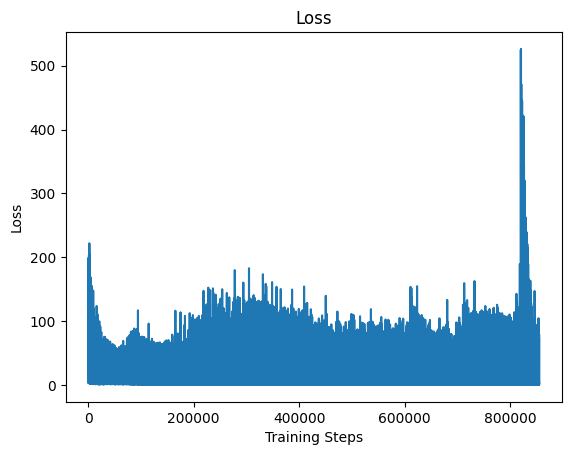

In [ ]:
# Tính giá trị trung bình động của loss
window_size = 100
moving_avg_losses = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
plt.figure(figsize=(12, 5))
plt.plot(moving_avg_losses)
plt.title("Moving Average Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.show()

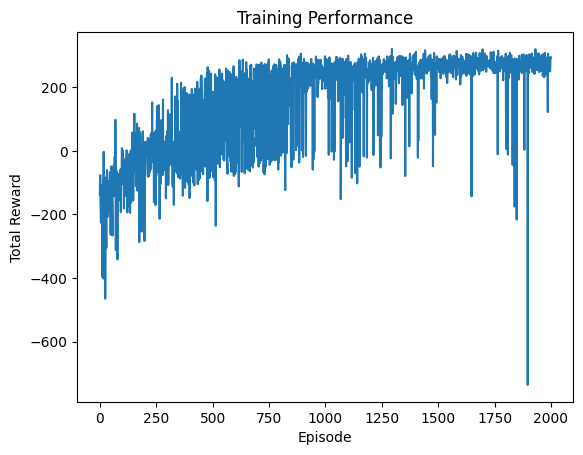

In [ ]:
# Tính toán trung bình động của phần thưởng
window_size = 100
moving_avg_reward = np.convolve(reward_list, np.ones(window_size)/window_size, mode='valid')
# Vẽ biểu đồ phần thưởng
plt.figure(figsize=(12, 6))
plt.plot(moving_avg_reward)
plt.title("Moving Average Reward")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.show()

### 12. Sample Video

In [ ]:
video_path = glob.glob("video_folder/*.mp4")[random.randint(0, len(glob.glob("video_folder/*.mp4")) - 1)]
Video(video_path, embed=True)